In [39]:
from sklearn.datasets import make_circles
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn
import numpy as np

In [2]:


train , target = make_circles(n_samples=1000)
train_df = pd.DataFrame(train , columns=[f'feature{i}' for i in range(train.shape[1])])
target_df = pd.DataFrame(target , columns=['target'])

df = pd.concat([train_df , target_df] , axis=1)
df.head()

,feature0,feature1,target
0,0.988652,0.150226,0
1,0.882291,-0.470704,0
2,-0.705833,-0.376563,1
3,-0.540266,-0.590010,1
4,0.778462,-0.627691,0


In [3]:
from sklearn.model_selection import train_test_split 
xtrain , xtest , ytrain, ytest = train_test_split(train, target , test_size=0.2)
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape


((800, 2), (200, 2), (800,), (200,))

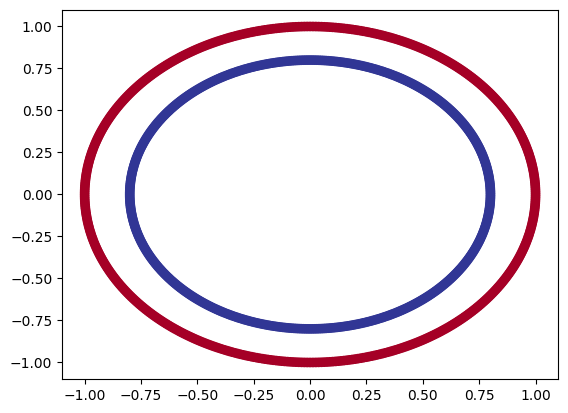

In [4]:
plt.scatter(train[:, 0] , train[:, 1] , c=target , cmap=plt.cm.RdYlBu)

In [5]:
train = torch.from_numpy(train).type(torch.float32)
target = torch.from_numpy(target).type(torch.float32)

In [28]:
class CircleModel(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.layer1 = nn.Linear(in_features=2 , out_features=8)
        self.layer2 = nn.Linear(in_features=8 , out_features=4)
        self.layer3 = nn.Linear(in_features=4 , out_features=2)
        self.layer4 = nn.Linear(in_features=2 , out_features=1)

    def forward(self , x:torch.tensor)->torch.tensor: 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    

model = CircleModel() 

In [11]:
next(model.parameters()).device

device(type='cpu')